In [139]:
M = 64
selected_tau = 2.45

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.autonotebook import tqdm

## Importing Datasets

In [141]:
string_df = pd.read_csv("../../data/interim/string_df.csv")

balanced_pairs_df = pd.read_csv("../../data/train_test/test_pairs.csv", index_col=0)

combinations_df = pd.read_csv("../../data/train_test/10_combinations_df.csv", index_col=0)

balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [142]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
1,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
2,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
3,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
4,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
...,...,...
951,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
952,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...
953,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
954,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...


In [143]:
# combinations_df = combinations_df[combinations_df['length']]

In [144]:
string_df["concatenated"] = string_df["concatenated"].apply(
    lambda x: np.array(list(x)).astype(int)
)

## Importing Best Configurations

In [145]:
import re
import pandas as pd


def parse_log_file(filename):
    data = []

    with open(filename, "r") as file:
        lines = file.readlines()

        current_filter = None
        current_threshold = None
        current_min_error = None
        current_confidence = None

        for line in lines:
            if "Best Filter" in line:
                # Extract Best Filter using regex
                filter_match = re.search(r"Best Filter: (.+)", line)
                if filter_match:
                    current_filter = filter_match.group(1).strip()

            elif "Best Threshold" in line:
                # Extract Best Threshold using regex
                threshold_match = re.search(r"Best Threshold: (.+)", line)
                if threshold_match:
                    current_threshold = int(threshold_match.group(1).strip())

            elif "Min error" in line:
                # Extract Min Error using regex
                min_error_match = re.search(r"Min error: (.+)", line)
                if min_error_match:
                    current_min_error = float(min_error_match.group(1).strip())

            elif "Confidence" in line:
                # Extract Confidence using regex
                confidence_match = re.search(r"Confidence: (.+)", line)
                if confidence_match:
                    current_confidence = float(confidence_match.group(1).strip())

                    # Once we have all values, create a tuple and add it to the data list
                    data.append(
                        (
                            current_filter,
                            current_threshold,
                            current_min_error,
                            current_confidence,
                        )
                    )

                    # Reset current values for the next entry
                    current_filter = None
                    current_threshold = None
                    current_min_error = None
                    current_confidence = None

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(
        data, columns=["Best Filter", "Best Threshold", "Min Error", "Confidence"]
    )

    return df

In [146]:
# Usage example:
filename = "../../reports/best_config"
best_configs_df = parse_log_file(filename)

In [147]:
best_configs_df

,Best Filter,Best Threshold,Min Error,Confidence
0,0[312] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1464],2,0.466147,0.135618
1,0[0] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[1768],6,0.466313,0.134951
2,0[328] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1448],1,0.469633,0.121620
3,0[248] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1528],1,0.467389,0.130630
4,0[8] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1768],3,0.466297,0.135016
...,...,...,...,...
230,0[488] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1288],1,0.451381,0.195092
231,0[1560] 🀫🀫🀫🀫🀆🀆🀆🀆 0[216],1,0.451381,0.195092
232,0[1160] 🀆🀆🀆🀆🀫🀫🀫🀫 0[616],1,0.451381,0.195092
233,0[776] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1000],1,0.451381,0.195092


In [148]:
if M != 0:
    best_configs_df = best_configs_df.head(M)

if M == 0:
    M = len(best_configs_df)

In [149]:
compression_rate = len(string_df["concatenated"].iloc[0]) / best_configs_df.shape[0]

print("Compression Rate:", compression_rate)

Compression Rate: 27.875


## Filters Parser

In [150]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "🀆":
                    result.append(-1)
                elif char == "🀫":
                    result.append(1)

    return result

## Apply Filters

In [151]:
def apply_filter(item, filter):
    # item = np.array(list(item)).astype(int)
    item = item.astype(int)
    filter = filter_parser(filter)
    return np.sum(np.multiply(item, filter))

In [152]:
def apply_filter_threshold(item, filter, threshold) -> int:
    if apply_filter(item, filter) > threshold:
        return 1
    else:
        return -1

In [153]:
def apply_filter_threshold_pair(item_1, item_2, filter, threshold) -> int:
    if apply_filter_threshold(item_1, filter, threshold) == apply_filter_threshold(
        item_2, filter, threshold
    ):
        return 1
    else:
        return -1

## Calculate Fingerprint

In [154]:
def hamming_distance(array1, array2, confidence):
    # Check if arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize distance counter
    distance = 0

    # Iterate through arrays and count differences
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += confidence[i]

    distance = (distance / sum(confidence)) * len(confidence)

    return distance

In [155]:
def calculate_fingerprint(item, best_filters, best_thresholds, confidence):
    fingerprint = []

    for best_filter, best_threshold in zip(best_filters, best_thresholds):
        filtered = np.sum(np.multiply(item.astype(int), filter_parser(best_filter)))

        if filtered > best_threshold:
            filtered = 1
        else:
            filtered = -1

        fingerprint.append(filtered)

    return fingerprint

In [156]:
fingerprints = []

In [157]:
for i, row in tqdm(string_df.iterrows(), total=string_df.shape[0]):
    # Extracting best filters and thresholds from the main DataFrame
    best_filters = best_configs_df["Best Filter"].tolist()
    best_thresholds = best_configs_df["Best Threshold"].tolist()
    confidence = best_configs_df["Confidence"].tolist()

    # Calculate the fingerprint using the relevant best filters and thresholds
    fingerprint = calculate_fingerprint(
        row["concatenated"], best_filters, best_thresholds, confidence
    )

    # Store the result in the 'fprint' column
    # string_df.at[i, "fprint"] = fingerprint
    fingerprints.append(fingerprint)

  0%|          | 0/956 [00:00<?, ?it/s]

In [158]:
string_df["fprint"] = fingerprints

In [159]:
string_df = string_df.reset_index(inplace=False, drop=True)

## Clustering w/ $\tau$

In [160]:
string_df.iloc[0, 2]

[1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [161]:
hamming_distance(string_df.iloc[0, 2], string_df.iloc[1, 2], confidence) - selected_tau

-0.4450205553186204

In [162]:
def predict(string_1, string_2, tau):
    if hamming_distance(string_1, string_2, confidence) < tau:
        return 1
    else:
        return -1

In [163]:
predict(string_df.iloc[0, 2], string_df.iloc[100, 2], selected_tau)

-1

## Clustering

In [164]:
import numpy as np
import pandas as pd
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [165]:
def hamming_distance(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must be of the same length")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def predict(string_1, string_2, tau):
    return 1 if hamming_distance(string_1, string_2) < tau else -1

In [166]:
# def cluster_dataset(df: pd.DataFrame, tau: float) -> np.ndarray:
#     n = len(df)
#     clusters = np.full(n, -1)  # -1 indicates that the item hasn't been clustered yet
#     next_cluster_id = 0
    
#     for i in range(n):
#         if clusters[i] == -1:  # If not yet clustered
#             clusters[i] = next_cluster_id
#             for j in range(i + 1, n):
#                 if predict(df['fprint'][i], df['fprint'][j], tau) == 1:
#                     clusters[j] = next_cluster_id
#             next_cluster_id += 1
    
#     return clusters


In [167]:
def cluster_dataset(df: pd.DataFrame, tau: float) -> np.ndarray:
    # Check if 'fprint' column exists
    if 'fprint' not in df.columns:
        raise ValueError("DataFrame must contain 'fprint' column.")
    
    n = len(df)
    clusters = np.full(n, -1)  # -1 indicates that the item hasn't been clustered yet
    next_cluster_id = 0
    
    for i in range(n):
        if clusters[i] == -1:  # If not yet clustered
            clusters[i] = next_cluster_id
            for j in range(i + 1, n):
                try:
                    # Ensure indices are valid before accessing
                    if i < len(df) and j < len(df):
                        if predict(df['fprint'].iloc[i], df['fprint'].iloc[j], tau) == 1:
                            clusters[j] = next_cluster_id
                except KeyError as e:
                    print(f"KeyError encountered: {e}. Skipping index {j}.")
                except IndexError as e:
                    print(f"IndexError encountered: {e}. Skipping index {j}.")
            next_cluster_id += 1
    
    return clusters

In [168]:
# clusters = cluster_dataset(string_df, selected_tau)

# # Ground truth labels
# true_labels = string_df['label'].to_numpy()

# # Calculate metrics
# homogeneity = homogeneity_score(true_labels, clusters)
# completeness = completeness_score(true_labels, clusters)
# v_measure = v_measure_score(true_labels, clusters)

# print(f"Homogeneity: {homogeneity}")
# print(f"Completeness: {completeness}")
# print(f"V-Measure: {v_measure}")

In [169]:
# string_df['cluster'] = clusters

In [170]:
string_df

,label,concatenated,fprint
0,GooglePixel3A_L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1..."
1,GooglePixel3A_L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1,..."
2,GooglePixel3A_L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, ..."
3,GooglePixel3A_L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1,..."
4,GooglePixel3A_L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1..."
...,...,...,...
951,iPhoneXSMax_M,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[-1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1..."
952,iPhoneXSMax_M,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[-1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, ..."
953,iPhoneXSMax_M,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[-1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -..."
954,iPhoneXSMax_M,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[-1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, ..."


In [171]:
import ast

In [172]:
def str_to_list(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return s 

In [173]:
results = []

In [174]:
for index, row in combinations_df.iterrows():
    combination = str_to_list(index)
    length = row['length']
    
    subset_df = string_df[string_df['label'].isin(combination)]

    true_labels = subset_df['label'].to_numpy()
    clusters = cluster_dataset(subset_df, selected_tau)

    subset_df.loc[:, 'cluster'] = clusters

    homogeneity = homogeneity_score(true_labels, clusters)
    completeness = completeness_score(true_labels, clusters)
    v_measure = v_measure_score(true_labels, clusters)
    rmse = np.sqrt(np.mean((subset_df['label'].nunique() - subset_df['cluster'].nunique())**2))

    results.append([length, homogeneity, completeness, v_measure, rmse])


/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_2739/3014516319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'cluster'] = clusters
/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_2739/3014516319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'cluster'] = clusters
/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_2739/3014516319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_clustering_metrics(results, filename):
    """
    Plots clustering metrics (Homogeneity, Completeness, V-Measure, RMSE) against the length.

    Parameters:
    results (list): A list of lists, where each inner list contains length and the four metrics.

    """
    if not results:
        print("No results to plot.")
        return

    # Convert the results list to a DataFrame
    df = pd.DataFrame(results, columns=['length', 'homogeneity', 'completeness', 'v_measure', 'rmse'])

    # Sorting the DataFrame by 'length' for better visualization
    df = df.sort_values('length')

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(4, 1, figsize=(8.3, 11.7))

    # fig.suptitle("Clustering Metrics vs. Length", fontsize=18)

    # Subplot for Homogeneity
    sns.lineplot(
        ax=axes[0],
        x='length',
        y='homogeneity',
        data=df,
        label='Homogeneity',
        marker='o',
        linewidth=2
    )
    axes[0].set_title('Homogeneity Score', fontsize=16)
    axes[0].set_xlabel('Length', fontsize=14)
    axes[0].set_ylabel('Score', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)

    # Subplot for Completeness
    sns.lineplot(
        ax=axes[1],
        x='length',
        y='completeness',
        data=df,
        label='Completeness',
        marker='o',
        linewidth=2
    )
    axes[1].set_title('Completeness Score', fontsize=16)
    axes[1].set_xlabel('Length', fontsize=14)
    axes[1].set_ylabel('Score', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)

    # Subplot for V-Measure
    sns.lineplot(
        ax=axes[2],
        x='length',
        y='v_measure',
        data=df,
        label='V-Measure',
        marker='o',
        linewidth=2
    )
    axes[2].set_title('V-Measure Score', fontsize=16)
    axes[2].set_xlabel('Length', fontsize=14)
    axes[2].set_ylabel('Score', fontsize=14)
    axes[2].tick_params(axis='both', which='major', labelsize=12)

    # Subplot for RMSE
    sns.lineplot(
        ax=axes[3],
        x='length',
        y='rmse',
        data=df,
        label='RMSE',
        marker='o',
        linewidth=2
    )
    axes[3].set_title('RMSE', fontsize=16)
    axes[3].set_xlabel('Length', fontsize=14)
    axes[3].set_ylabel('RMSE', fontsize=14)
    axes[3].tick_params(axis='both', which='major', labelsize=12)

    # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the plot as a PDF file
    plt.savefig(filename, format='pdf')

    plt.show()


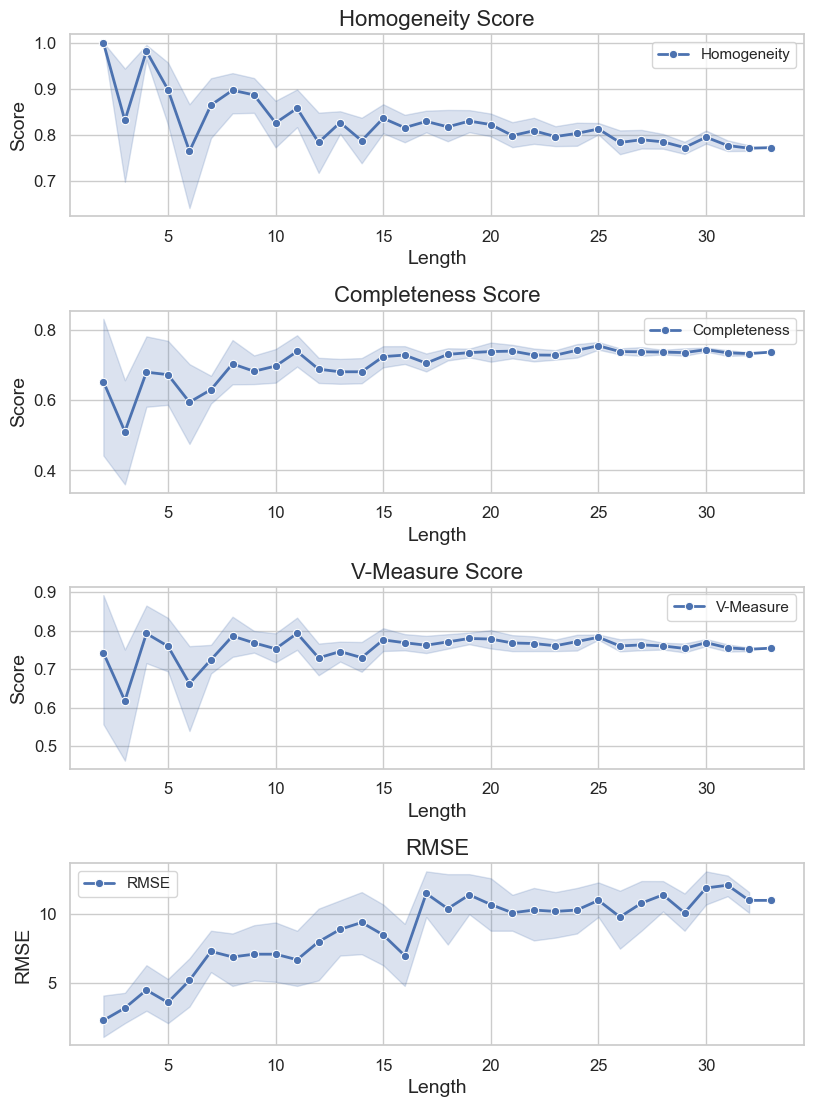

In [176]:
plot_clustering_metrics(results, '../../reports/figures/tau_clustering_metrics.pdf')

In [177]:
results_df = pd.DataFrame(results, columns=['length', 'homogeneity', 'completeness', 'v_measure', 'rmse'])
results_df.to_csv(f'../../reports/CSV/clustering/clustering_results_{M}.csv', index=False)
